In [1]:
using ReinforcementLearning
using Flux
using Flux.Losses
using IntervalSets
using StableRNGs
using Plots
# using CUDA
# using ControlSystems
using FurutaPendulums
using BSON

In [46]:
mutable struct MPCEnv <: AbstractEnv
    state
    reward::AbstractFloat
    action_space
    state_space
    done
    furuta
    t
    dt
    tmax
    last_time
    N
    track
end

function MPCEnv(;
    N = 4,
    max_dθ=100.,
    max_dϕ=100.,
    dt = 0.01,
    tmax = 5.
    )
max_u=[5. for i in 1:N]
high = [2*pi,max_dθ,2*pi,max_dϕ]
low = [0,-max_dθ,0,-max_dϕ]
furuta = SimulatedFurutaPendulum()

MPCEnv(
    measure(furuta),
    0.,
    Space(ClosedInterval{Float64}.(-max_u, max_u)),
    Space(ClosedInterval{Float64}.(low, high)),
    false,
    furuta,
    0.,
    dt,
    tmax,
    time(),
    N,
    zeros(4,N+1)
    )
end

RLBase.action_space(env::MPCEnv) = env.action_space
RLBase.state_space(env::MPCEnv) = env.state_space
function RLBase.reward(env::MPCEnv)
    # ϕ, ϕdot, θ, θdot = env.state
    env.reward = sum( cos(env.track[3, i]) - abs(0.01*env.track[2, i]^2)) for i in 2:env.N+1) #sum(( -2*abs(1 - cos(env.track[3, i]) - 0.0021 * env.track[4, i]^2) - abs(0.001*env.track[2, i]^2) ) for i in 2:env.N+1)  # Define the cost function
end
RLBase.is_terminated(env::MPCEnv) = env.done
RLBase.state(env::MPCEnv) = env.state

function (env::MPCEnv)(a::Vector{Float32})
    @assert a in env.action_space
    dt = env.dt
    furuta2 = SimulatedFurutaPendulum()
    env.track = zeros(4,env.N+1)
    env.track[:,1] = env.state
    furuta2.x = env.state
    for i in 1:env.N
        control(furuta2,a[i])
        periodic_wait(furuta2,env.t,env.dt)
        env.track[:,i+1] = measure(furuta2)
    end
    control(env.furuta,a[1])
    env.last_time = periodic_wait(env.furuta,env.last_time,env.dt)
    env.state[:] = measure(env.furuta)
    env.t += env.dt
    env.done = env.t >= env.tmax
end

function RLBase.reset!(env::MPCEnv)
    env.last_time = time()
    env.reward = 0.
    env.t = 0.
    env.furuta = SimulatedFurutaPendulum()
    env.state = measure(env.furuta)
    env.done = false
end

LoadError: syntax: "function" at In[46]:46 expected "end", got "for"

In [43]:
struct PIDNeuralNet
    chain::Chain
end
function (m::PIDNeuralNet)(x)
    return m.chain(x)[1]
end
Flux.@functor PIDNeuralNet

In [21]:
run(
           RandomPolicy([-5. for i in 1:3]..[5. for i in 1:3]; rng = StableRNG(123)),
        #    ex.policy,
        #    model,
           MPCEnv(),
           StopAfterEpisode(10),
           TotalRewardPerEpisode()
       )

                ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                ┌────────────────────────────────────────┐ 
              0 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⡄⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠎⠈⢆⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠎⠀⠀⠀⠣⡀⠀⠀⠀⠀⠀│ 
   Score        │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠜⡄⠀⠀⠀⠀⠀⠀⠀⠀⢀⠎⠀⠀⠀⠀⠀⠱⡀⣀⣀⡠⠤│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠊⠀⠘⡄⠀⠀⠀⠀⠀⠀⢀⠎⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡰⠁⠀⠀⠀⠸⡀⠀⠀⠀⠀⢠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠜⠀⠀⠀⠀⠀⠀⠱⡀⠀⠀⡰⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠤⠤⠤⠤⠤⠤⣀⡀⠀⢀⠤⠊⠁⠀⠀⠀⠀⠀⠀⠀⠀⢱⢀⠜⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠈⠉⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -20000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

TotalRewardPerEpisode([-15393.473693095073, -15351.440675755186, -16241.373121143592, -14247.402149979845, -9638.744866654364, -16364.326087672012, -12004.579513202829, -6141.118609220622, -10742.428445603615, -10060.803249490089], 0.0, true)

In [44]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    env = MPCEnv()
    A = action_space(env)
    ns = length(state(env))
    init = glorot_uniform(rng)
    na = env.N

    # create_actor() = Chain(
    #     Dense(ns, 32, relu; init = init),
    #     Dense(32, 32, relu; init = init),
    #     Dense(32, na, tanh; init = init),
    # ) |> cpu

    function create_actor()
        chain = Chain(
            Dense(ns, 32, relu; init = init),
            Dense(32, 32, relu; init = init),
            Dense(32, ns, identity; init = init),
        )
        model = PIDNeuralNet(chain)
        return model |> cpu
    end

    create_critic_model() = Chain(
        Dense(ns + 1, 32, relu; init = init),
        Dense(32, 32, relu; init = init),
        Dense(32, 1; init = init),
    ) |> cpu

    create_critic() = TD3Critic(create_critic_model(), create_critic_model())

    agent = Agent(
        policy = TD3Policy(
            behavior_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            target_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            target_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            γ = 0.99f0,
            ρ = 0.99f0,
            batch_size = 64,
            start_steps = 1000,
            start_policy = RandomPolicy([-5. for i in 1:na]..[5. for i in 1:na]; rng = rng),
            update_after = 1000,
            update_freq = 1,
            policy_freq = 2,
            target_act_limit = 5.0,
            target_act_noise = 0.1,
            act_limit = 5.0,
            act_noise = 0.1,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 500_000,
            state = Vector{Float32} => (ns,),
            action = Vector{Float32} => (na,),
            # action = Float64 => (na),
        ),
    )

    #stop_condition = StopAfterStep(10000, is_show_progress=!haskey(ENV, "CI"))
    stop_condition = StopAfterEpisode(10; cur = 0, is_show_progress = true)
    hook = TotalRewardPerEpisode() 
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

In [45]:
ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook.rewards)

# Play Pendulum with TD3


LoadError: MethodError: no method matching vec(::Float64)
[0mClosest candidates are:
[0m  vec([91m::LinearAlgebra.Transpose{<:Number, <:AbstractVector}[39m) at C:\Users\Hashim\.julia\juliaup\julia-1.8.5+0.x64.w64.mingw32\share\julia\stdlib\v1.8\LinearAlgebra\src\adjtrans.jl:219
[0m  vec([91m::LinearAlgebra.Adjoint{<:Real, <:AbstractVector}[39m) at C:\Users\Hashim\.julia\juliaup\julia-1.8.5+0.x64.w64.mingw32\share\julia\stdlib\v1.8\LinearAlgebra\src\adjtrans.jl:220
[0m  vec([91m::SparseArrays.AbstractSparseVector[39m) at C:\Users\Hashim\.julia\juliaup\julia-1.8.5+0.x64.w64.mingw32\share\julia\stdlib\v1.8\SparseArrays\src\sparsevector.jl:968
[0m  ...

[ Info: Saved animation to c:\Users\Hashim\group-2\unfinished\anim_pendulum.gif


Plots.AnimatedGif("c:\\Users\\Hashim\\group-2\\unfinished\\anim_pendulum.gif")
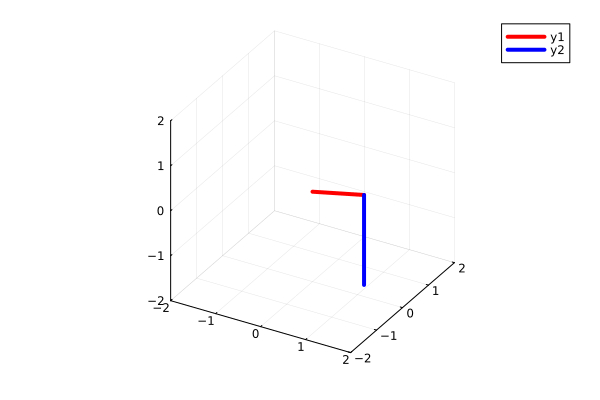

In [21]:
include("../src/sim/env.jl")

env = MPCEnv()
tmax = 20.
tspan = 0.:env.dt:tmax
xs = zeros(length(tspan),4)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    u = [0.3,0.,0.,0.,0.,0.,0.,0.,0.,0.]
    env(u)
end
animate_pendulum(xs[:,1],xs[:,3],tmax)

In [98]:
env = MPCEnv()
RLBase.test_runnable!(env)

Test Summary:             | Pass  Total  Time
random policy with MPCEnv | 2000   2000  0.0s


Test.DefaultTestSet("random policy with MPCEnv", Any[], 2000, false, false, true, 1.685297486859e9, 1.685297486892e9)